In [121]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Inicialización de parametros

In [122]:
def random_initialization(layers_dims):
    parameters = {}
    L = len(layers_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l-1], layers_dims[l]) * 0.01
        parameters['b' + str(l)] = np.zeros((1, layers_dims[l]))

    return parameters

# Funciones de activación

In [123]:
def relu(x):
    return np.maximum(0, x)

In [124]:
def relu_derivative(x):
  return np.where(x > 0, 1, 0)

In [125]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Forward propagation

In [126]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # Layer 1: Linear -> ReLU
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)

    # Layer 2: Linear -> ReLU
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)

    # Layer 3: Linear -> Softmax
    z3 = np.dot(a2, W3) + b3
    a3 = softmax(z3)

    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    return a3, cache

# Backward Propagation

In [127]:
def backward_propagation(X, y, cache):

    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    m = X.shape[0]

    dz3 = a3 - y
    dW3 = np.dot(a2.T, dz3) / m
    db3 = np.sum(dz3, axis=0, keepdims=True) / m

    # Compute gradients for the second hidden layer
    da2 = np.dot(dz3, W3.T)
    dz2 = da2 * relu_derivative(a2)  # Applying the ReLU derivative
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m

    # Compute gradients for the first hidden layer
    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * relu_derivative(a1)  # Applying the ReLU derivative
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m

    gradients = {'dz1': dz1, 'dA1': da1, 'dW1': dW1, 'db1': db1, 'dz2': dz2, 'dA2': da2, 'dW2': dW2, 'db2': db2, 'dz3': dz3, 'dW3': dW3, 'db3': db3}

    return gradients


# Función de costo

In [128]:
def compute_cost(a3, y_true):
    
    m = y_true.shape[0]  

    # Compute cross-entropy loss
    cost = -np.sum(y_true * np.log(a3 + 1e-8)) / m  

    return cost

# Optimizadores

In [129]:
class EstocasticOptimizer():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    
    def update(self, parameters, grads):
        L = len(parameters) // 2 
    
        for l in range(L):
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * grads["dW" + str(l + 1)]
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * grads["db" + str(l + 1)]
        return parameters

In [130]:
class AdamOptimizer():
    def __init__(self, parameters, learning_rate):
        self.v = {}
        self.s = {}
        self.learning_rate = learning_rate
        L = len(parameters) // 2

        for l in range(L):
            self.v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

            self.s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])

    def update(self, parameters, grads, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
        L = len(parameters) // 2                 # number of layers in the neural networks
        v_corrected = {}                         # Initializing first moment estimate, python dictionary
        s_corrected = {}                         # Initializing second moment estimate, python dictionary

        # Perform Adam update on all parameters
        for l in range(L):
            # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
            self.v["dW" + str(l + 1)] = beta1 * self.v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
            self.v["db" + str(l + 1)] = beta1 * self.v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

            # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
            v_corrected["dW" + str(l + 1)] = self.v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
            v_corrected["db" + str(l + 1)] = self.v["db" + str(l + 1)] / (1 - np.power(beta1, t))

            # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
            self.s["dW" + str(l + 1)] = beta2 * self.s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
            self.s["db" + str(l + 1)] = beta2 * self.s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

            # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
            s_corrected["dW" + str(l + 1)] = self.s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
            s_corrected["db" + str(l + 1)] = self.s["db" + str(l + 1)] / (1 - np.power(beta2, t))

            # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(self.s["dW" + str(l + 1)] + epsilon)
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(self.s["db" + str(l + 1)] + epsilon)

        return parameters

# Modelo

In [131]:
def model(X, Y, layers_dims, learning_rate=0.01, num_epochs=10000, print_cost=True, optimizer_use="Adam"):

    L = len(layers_dims)             
    costs = []                                                                     
    t = 0
    # Initialize parameters
    parameters = random_initialization(layers_dims)
    if optimizer_use == "Adam": optimizer=AdamOptimizer(parameters,learning_rate=learning_rate)
    if optimizer_use == "Estocastic": optimizer=EstocasticOptimizer(learning_rate=learning_rate)

    # Optimization loop
    for i in range(num_epochs):

        # Forward propagation
        a3, cache = forward_propagation(X, parameters)

        # Compute cost
        cost = compute_cost(a3, Y)

        # Backward propagation
        grads = backward_propagation(X, Y, cache)
        
        
        t+=1
        if optimizer_use == "Adam": parameters=optimizer.update(parameters,grads,t,learning_rate)
        if optimizer_use == "Estocastic": parameters=optimizer.update(parameters,grads)
       
        if print_cost and i % 1000 == 0:
            print("Cost after epoch %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
        
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title(f"Optimizador: {optimizer_use}; Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters

# Predicción

In [132]:
def predict(X, parameters, y_test):
    """
    Generate predictions for input data X using the trained parameters.

    X: input data (shape: (number of samples, number of features))
    parameters: dictionary containing weights and biases of the network

    Returns:
    predictions: predicted class labels (shape: (number of samples,))
    """
    # Perform forward propagation
    a3, _ = forward_propagation(X, parameters)


    # Convert probabilities to class labels
    predictions = np.argmax(a3, axis=1)  # Select class with highest probability
    
    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_labels, predictions)

    return predictions, accuracy


In [133]:
iris = load_iris()
X = iris.data  # Keep X as (150, 4)
y = iris.target.reshape(-1, 1)

# One-hot encode y
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)  # Now y_onehot has shape (150, 3)

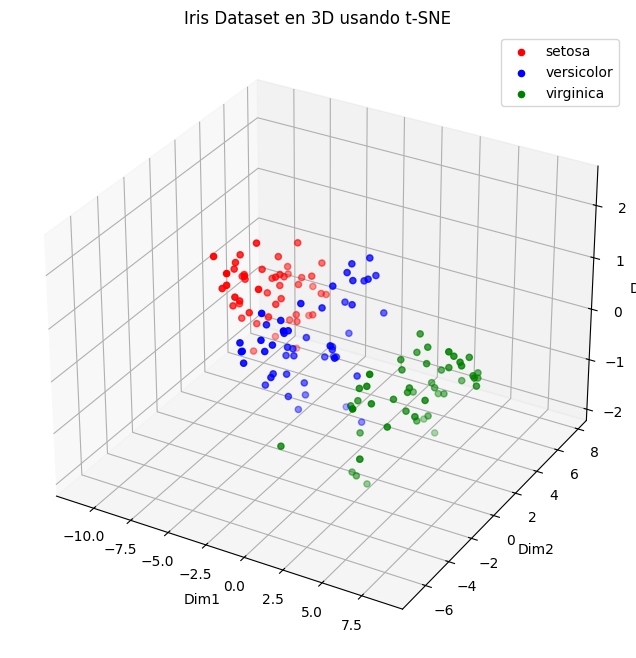

In [134]:
# Reducir dimensiones con t-SNE a 3 dimensiones
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_reduced = tsne.fit_transform(X)

# Convertir a DataFrame para manipulación y visualización
df = pd.DataFrame(X_reduced, columns=['Dim1', 'Dim2', 'Dim3'])
df['target'] = y

# Colores para cada clase
colors = ['red', 'blue', 'green']
target_names = iris.target_names

# Graficar en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, target_name in enumerate(target_names):
    ax.scatter(df.loc[df['target'] == i, 'Dim1'],
               df.loc[df['target'] == i, 'Dim2'],
               df.loc[df['target'] == i, 'Dim3'],
               label=target_name, color=colors[i])

# Etiquetas y título
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
ax.set_title('Iris Dataset en 3D usando t-SNE')
ax.legend()
plt.show()

Cost after epoch 0: 1.098609
Cost after epoch 1000: 0.022345
Cost after epoch 2000: 0.021647
Cost after epoch 3000: 0.016490
Cost after epoch 4000: 0.014440
Cost after epoch 5000: 0.009924
Cost after epoch 6000: 0.008145
Cost after epoch 7000: 0.005820
Cost after epoch 8000: 0.004743
Cost after epoch 9000: 0.004193


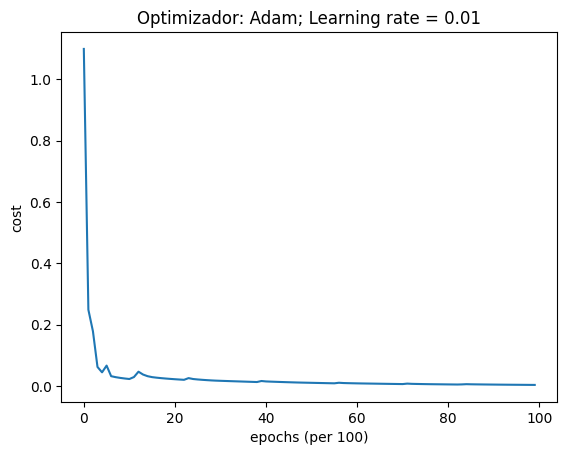

In [135]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=156477 , shuffle=True)

layers_dims = [X.shape[1], 10, 8, 3]

parameters = model(X_train, y_train, layers_dims, optimizer_use="Adam")

In [136]:
predictions, accuracy = predict(X_test, parameters, y_test)
print(f'Las predicciones son: {predictions}')
print(f'La exactitud es de: {accuracy*100:.2f} %')


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


# Matriz de confusión 

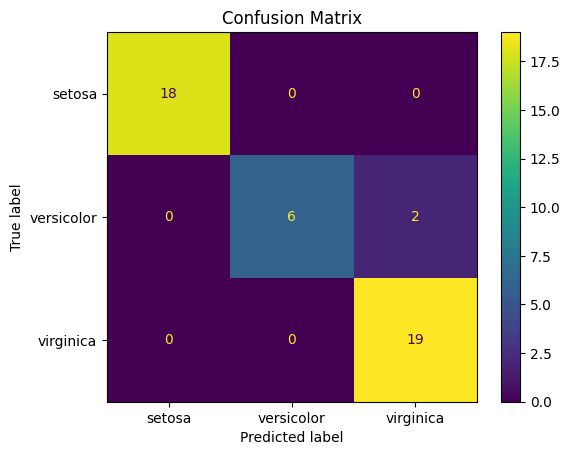

In [137]:
y_test_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot()
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()
